# step4: validation 

### validation imageset --> patch

In [30]:
import glob
import cv2
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns;sns.set()
torch.manual_seed(0)

In [3]:
### validation set for validation
import glob
import cv2

validation_images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob("./data/nocrop/val/*.png"))]
print(validation_images[0].shape)
print(len(validation_images))

(256, 4096)
80


In [4]:
""" 
patch로 쪼개주는 함수
: image list를 받아서, tensor로 변환 
-> .view(패치개수, 패치사이즈, 패치사이즈)
-> train_patches.shape = 85 256 64 64 / val_for_training_patches.shape = 28 256 64 64
"""
def patch(images):
  patch_size = 64
  for i in range(len(images)):
    images[i] = transforms.ToTensor()((images[i]))
    # unfold로 shape조절 --> view --> [patch개수, patch_size, patch_size]
    patches = images[i].data.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size) 
    patches = patches.contiguous().view(-1, patch_size, patch_size) 

    if i == 0:
      patch = patches
    if i > 0:
      patches = torch.cat((patch, patches))
      patch = patches


  patches = patches.view(len(images), -1, patch_size, patch_size) 
  return patches

In [5]:
## validation 이미지(정상28, 결함52--> 총 80개)를 patch tensor로 만들어줌
## validation_patches: 80, 256, 64, 64
validation_patches = patch(validation_images)

### original image & reconstructed images visualization


In [16]:
"""
AE based on CNN 모델이 제대로 패치 이미지를 reconstruct하는지 확인하기 위해
visualization하는 코드
"""
def visualization(model_num, validation_patches):
  device = 'cpu'
  ## model load
  models = [Autoencoder1().to(device), Autoencoder2().to(device), 
            Autoencoder3().to(device), Autoencoder4().to(device), Autoencoder5().to(device)]
  new_model= models[model_num-1]
  new_model.load_state_dict(torch.load("./model/finalepoch/Autoencoder{}.pth".format(model_num)))
  
  new_model.eval()

  img_idx = 0
  ## 한 이미지에 들어있는 patch들을 매 loop마다 불러온다. 
  ## 즉, 256개의 패치를 256, 64, 64 사이즈의 텐서로 불러온다.
  for patch in validation_patches:
    if img_idx < 53:
      img_idx += 1 
      continue
    # 예시로 defect 이미지 하나에 대한 patch들을 출력한다.
    elif img_idx == 53:
      ## 각 패치를 매 loop마다 불러온다.
      for patch_idx in range(256):
        original = patch[patch_idx].view(1,1,64,64)
        original = Variable(original).cpu()

        pred = new_model(original)
        pred = pred.view(64, 64).detach()

        if patch_idx >= 5:
          break
        ## original 패치 이미지 출력
        plt.subplot(1,2,1)
        plt.title("Original")
        plt.imshow(np.transpose(original.view(64,64), (0,1))*255.,cmap='gray', vmin=0, vmax=255)
        
        ## reconstructed 패치 이미지 출력
        plt.subplot(1,2,2)
        plt.title("Reconstructed")
        plt.imshow(np.transpose(pred,(0,1))*255.,cmap='gray', vmin=0, vmax=255)
        plt.show()
        img_idx += 1
    else:
      break
  

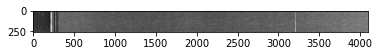

In [13]:
# patch로 잘라내기 이전의 원본 이미지
plt.imshow(validation_images[53].view(256,4096), cmap='gray')

In [ ]:
exec(open("./autoencoder.py").read())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

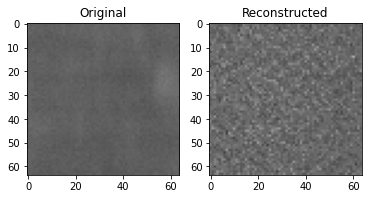

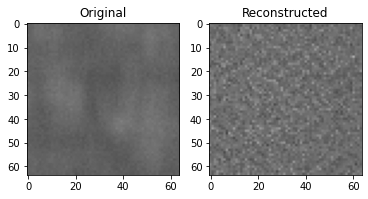

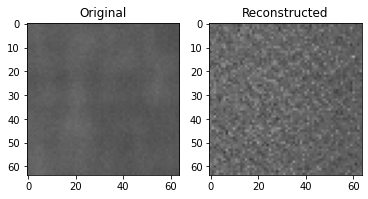

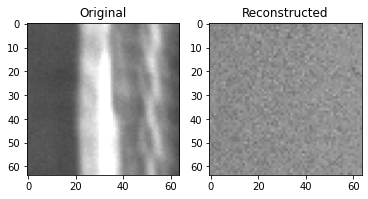

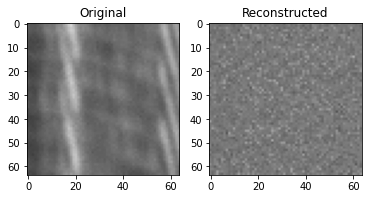

In [17]:
# model1
# Input original image -> AE -> Reconstructed image
visualization(1, validation_patches)

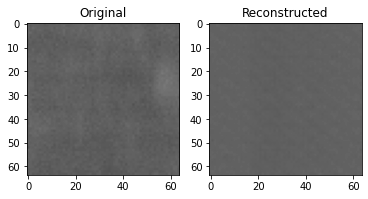

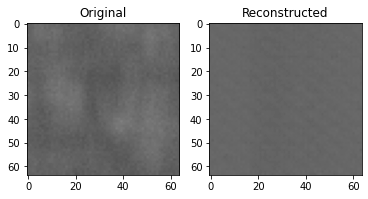

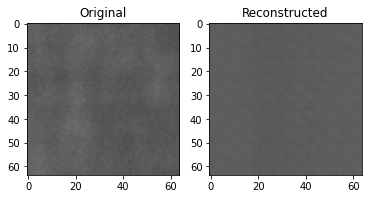

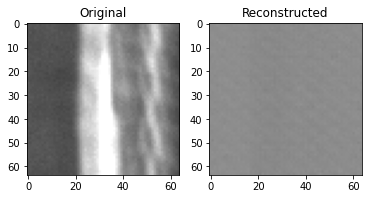

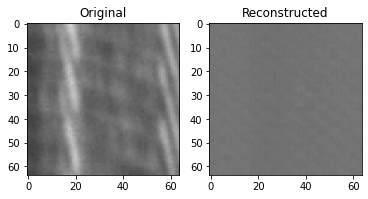

In [18]:
# model2
# Input original image -> AE -> Reconstructed image
visualization(2, validation_patches)

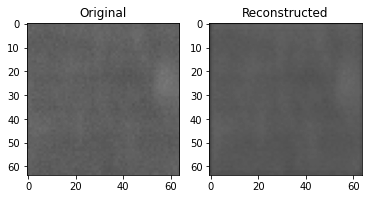

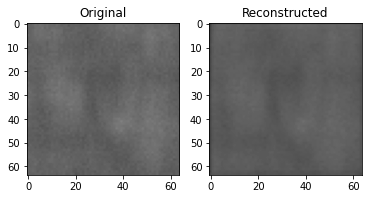

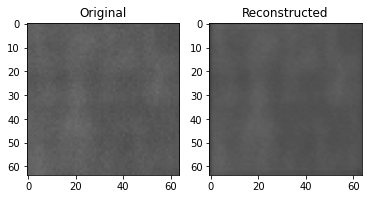

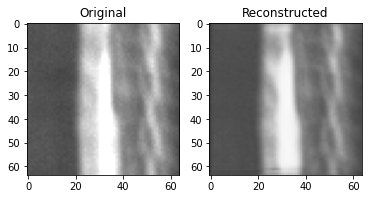

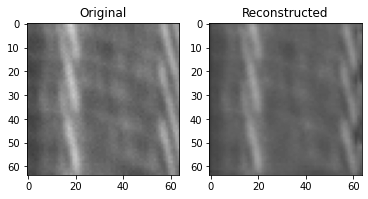

In [19]:
# model3
# Input original image -> AE -> Reconstructed image
visualization(3, validation_patches)

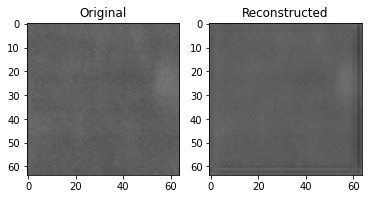

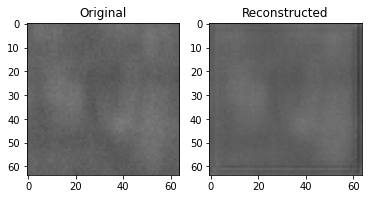

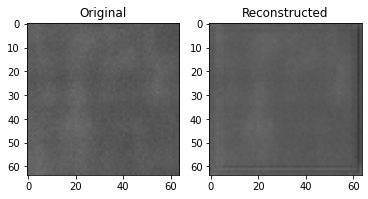

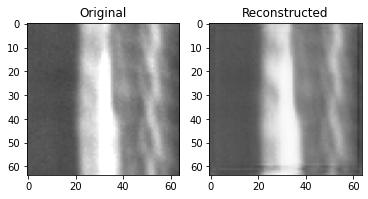

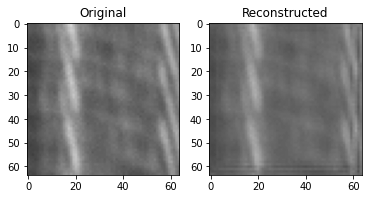

In [20]:
# model4
# Input original image -> AE -> Reconstructed image
visualization(4, validation_patches)

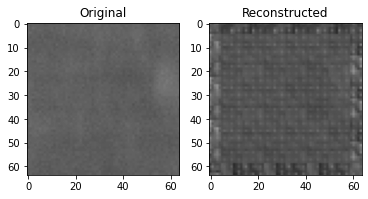

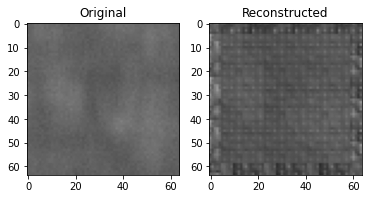

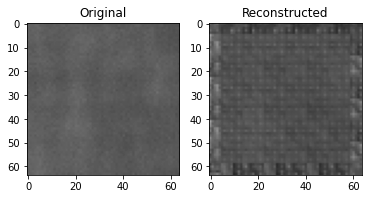

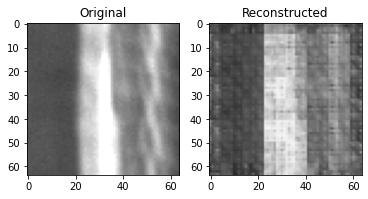

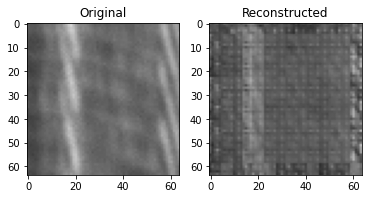

In [21]:
# model5 # cnn stride를 키웠을 때 재구성이 잘 되지않음. --> 모델 채택 x
# Input original image -> AE -> Reconstructed image
visualization(5, validation_patches)

### validation function 
- load model
- patch defectness detect(by patch_threshold)
- image defectness detect(by patch_num_threshold)

In [22]:
"""
defect로 판단된 patch 개수가 threshold이상이면,
해당 이미지를 defect로 판단하여 True를 return한다.
"""
def image_prediction(patch_num_threshold, defectness_list):
  defect_num = sum(defectness_list)
  if (defect_num >= patch_num_threshold):
    return True # defect patch가 k개 이상이면, 해당 이미지는 defect(True)
  return False

In [23]:
"""
patch 한 개에 대한 loss값이 threshold이상이면,
해당 patch를 defect를 판단하여 True를 return한다.
"""
def patch_prediction(loss, patch_threshold):
  if loss >= patch_threshold :
    return True
  else: 
    return False

In [28]:
"""
validation의 역할
1. patch threshold, image threshold 설정
2. 모델 성능평가: 
   model4개에 대해 patch threshold 3가지, image threshold 3가지를 적용
  --> f1 score가 가장 높은 모델과 threshold 선택
"""
def validation(model_num, validation_patches, k, threshold, cm):

  TP = 0
  TN = 0
  FN = 0 
  FP = 0
  img_idx = 0
  loss_func = nn.MSELoss()
  models = [Autoencoder1().to(device), Autoencoder2().to(device), 
            Autoencoder3().to(device), Autoencoder4().to(device), Autoencoder5().to(device)]
  new_model= models[model_num-1]
  new_model.load_state_dict(torch.load("./model/model{}/Autoencoder{}_epoch19.pth".format(model_num,model_num)))
  
  new_model.eval()
  y_true=[]
  y_pred=[]
  
  ## 한 이미지에 들어있는 patch들을 매 loop마다 불러온다. 
  ## 즉, 256개의 패치를 256, 64, 64 사이즈의 텐서로 불러온다.
  for patch in validation_patches:

    ## 원본 이미지들의 true label을 y_true에 저장
    if img_idx<28:
        y_true.append(0) #정상
    else:
        y_true.append(1)
    defectness_list = []
    
    ## 각 패치를 매 loop마다 불러온다.
    for patch_idx in range(256):
      one_patch = patch[patch_idx].view(1,1,64,64)
      one_patch = Variable(one_patch).cuda()
      pred = new_model(one_patch)
      loss = loss_func(pred, one_patch)
      # 각 patch의 결함여부가 T / F값으로 저장됨
      defectness = patch_prediction(loss, threshold ) 
      defectness_list.append(defectness)
    # 각 이미지의 결함여부가 T / F값으로 저장됨
    image_defectness = image_prediction(k, defectness_list)

    if img_idx < 28: # 실제 정상
      if image_defectness == True: #결함 판단(오류)
        FN += 1
        y_pred.append(1)
      else: # 정상 판단
        TN += 1
        y_pred.append(0)
    else: # 실제 결함
      if image_defectness == True: # 결함 판단
        TP += 1
        y_pred.append(1)
      else: # 정상 판단(오류)
        FP += 1 # want to minimize
        y_pred.append(0)
   
    img_idx += 1

  print("true:  정상  결함")
  print("pred: ", TN, " ", FP)
  print("      ", FN, " ", TP)

  f1score = f1_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  print("f1score=", f1score)
  print("accuracy=", accuracy)
  
  if cm == True:
    confusion_matrix2= confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix2.T, annot=True,fmt='d',
                xticklabels=['nodefect','defect'], yticklabels=['nodefect','defect'], cmap="YlGnBu")
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title('Confusion Matirx', fontsize=20)

  return f1score # 높을수록 성능 good 


```

"""
    REAL        정상              결함
PRED
정상      TN(정상-정상판단) FP(결함-정상판단)
결함      FN(정상-결함판단) TP(결함-결함판단)
"""
```


In [31]:
## 모델마다 9가지의 f1score를 저장

model_f1score =  torch.zeros(5,3,3)
image_threshold = [3,5,7]
patch_threshold = [0.0028, 0.005, 0.01]
# 모델 1~5
for model_num in range(1,6):
  print()
  print()
  print("model: Autoencoder", model_num)
  ## grid search
  # image_threshold 값이 하나씩 들어간다.
  for k in range(len(image_threshold)):
    # patch_threshold 값이 하나씩 들어간다.
    for j in range(len(patch_threshold)):
      print("image_threshold: ", image_threshold[k], "patch_threshold: ", patch_threshold[j])
      model_f1score[model_num-1][k][j] = validation(model_num, validation_patches, image_threshold[k], patch_threshold[j], False)

print(model_f1score)



model: Autoencoder 1
image_threshold:  3 patch_threshold:  0.0028
true:  정상  결함
pred:  0   0
       28   52
f1score= 0.787878787878788
accuracy= 0.65
image_threshold:  3 patch_threshold:  0.005
true:  정상  결함
pred:  0   0
       28   52
f1score= 0.787878787878788
accuracy= 0.65
image_threshold:  3 patch_threshold:  0.01
true:  정상  결함
pred:  0   2
       28   50
f1score= 0.7692307692307693
accuracy= 0.625
image_threshold:  5 patch_threshold:  0.0028
true:  정상  결함
pred:  0   0
       28   52
f1score= 0.787878787878788
accuracy= 0.65
image_threshold:  5 patch_threshold:  0.005
true:  정상  결함
pred:  0   0
       28   52
f1score= 0.787878787878788
accuracy= 0.65
image_threshold:  5 patch_threshold:  0.01
true:  정상  결함
pred:  4   4
       24   48
f1score= 0.7741935483870968
accuracy= 0.65
image_threshold:  7 patch_threshold:  0.0028
true:  정상  결함
pred:  0   0
       28   52
f1score= 0.787878787878788
accuracy= 0.65
image_threshold:  7 patch_threshold:  0.005
true:  정상  결함
pred:  0   0
      

** best:model 4 **
- image_threshold:  3
- patch_threshold:  0.0028
- f1score= 0.86

true:  정상  결함
pred:  19   6
       9   46
f1score= 0.8598130841121494
accuracy= 0.8125


0.8598130841121494

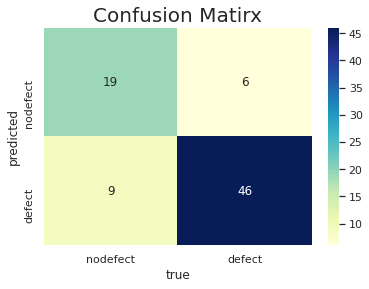

In [34]:
# best model의 Confusion matrix 출력
validation(4, validation_patches, 3, 0.0028, True)